In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
base_dir = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data"

dfs = []
for i in range(1, 43):
    sols_path = os.path.join(base_dir, f"maquette{i}", f"sols{i}.csv")
    if os.path.exists(sols_path):
        with open(sols_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(sols_path, sep=';', header=header_row)
            dfs.append(df)
            print(f"Chargé : {sols_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {sols_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {sols_path}")

if dfs:
    sols_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {sols_concat.shape[0]} lignes, {sols_concat.shape[1]} colonnes")
else:
    sols_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

sols_concat.head()

Chargé : /Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data/maquette1/sols1.csv (45 lignes, 142 colonnes)
       Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  860207        GO      PLANCHER            COURANT         PREDALLE USINE   
1  861048        GO      PLANCHER            COURANT         COULE EN PLACE   
2  862490        GO      PLANCHER            COURANT         PREDALLE USINE   
3  862746        GO      PLANCHER            COURANT         PREDALLE USINE   
4  862880        GO      PLANCHER            COURANT         PREDALLE USINE   

           Nom  Murs en intersection  Murs coupés (u)  \
0  Plancher 35                     0               46   
1  Plancher 32                     0               33   
2  Plancher 35                     0                9   
3  Plancher 35                     0               66   
4  Plancher 24                     9              360   

                                   Murs coupés (Ids)  Murs coupants (u) 

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,Murs en intersection,Murs coupés (u),Murs coupés (Ids),Murs coupants (u),...,str_terres,str_is_10,str_sur-place,str_extrait,Sol Niveau Fini,Sol Contrefleche,Classe Beton,Sol Description,Sol Epaisseur,STR_NIV_ref
0,860207,GO,PLANCHER,COURANT,PREDALLE USINE,Plancher 35,0,46,"846095,846097,846103,846107,846142,848603,8592...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,861048,GO,PLANCHER,COURANT,COULE EN PLACE,Plancher 32,0,33,"846059,846077,846118,846151,846152,846153,8728...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,862490,GO,PLANCHER,COURANT,PREDALLE USINE,Plancher 35,0,9,"846140,846142,848603,896351,896391,1263045,128...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,862746,GO,PLANCHER,COURANT,PREDALLE USINE,Plancher 35,0,66,"846103,846107,846126,846129,846140,846142,8486...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,862880,GO,PLANCHER,COURANT,PREDALLE USINE,Plancher 24,9,360,"846055,846057,846059,846060,846061,846064,8460...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
sols_concat.shape

(6422, 353)

In [4]:
print(sols_concat)

           Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation  \
0      860207        GO      PLANCHER            COURANT   
1      861048        GO      PLANCHER            COURANT   
2      862490        GO      PLANCHER            COURANT   
3      862746        GO      PLANCHER            COURANT   
4      862880        GO      PLANCHER            COURANT   
...       ...       ...           ...                ...   
6417  4532519        GO      PLANCHER            COURANT   
6418  4533778        GO      PLANCHER            COURANT   
6419  4559344        GO      PLANCHER            COURANT   
6420  4559459        GO      PLANCHER            COURANT   
6421  4559561        GO      PLANCHER            COURANT   

     014EC_Mode Constructif            Nom  Murs en intersection  \
0            PREDALLE USINE    Plancher 35                     0   
1            COULE EN PLACE    Plancher 32                     0   
2            PREDALLE USINE    Plancher 35                     0   
3      

In [5]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type",
    "Nom",
]

# On ne garde que les colonnes présentes dans le DataFrame
sols_concat = sols_concat[[col for col in colonnes_a_garder if col in sols_concat.columns]]

In [6]:
print(sols_concat.columns.tolist())

['011EC_Lot', '012EC_Ouvrage', '013EC_Localisation', '014EC_Mode Constructif', 'Epaisseur', 'Ouvertures', 'Profil modifié', 'Matériau structurel', 'Famille et type', 'Nom']


In [7]:
sols_concat

,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Epaisseur,Ouvertures,Profil modifié,Matériau structurel,Famille et type,Nom
0,GO,PLANCHER,COURANT,PREDALLE USINE,"0,35",0,False,ECSA - Béton Voiles,Sol: Plancher 35,Plancher 35
1,GO,PLANCHER,COURANT,COULE EN PLACE,"0,32",0,False,ECSA - Béton Voiles,Sol: Plancher 32,Plancher 32
2,GO,PLANCHER,COURANT,PREDALLE USINE,"0,35",0,False,ECSA - Béton Voiles,Sol: Plancher 35,Plancher 35
3,GO,PLANCHER,COURANT,PREDALLE USINE,"0,35",0,False,ECSA - Béton Voiles,Sol: Plancher 35,Plancher 35
4,GO,PLANCHER,COURANT,PREDALLE USINE,"0,24",0,False,ECSA - Béton Voiles,Sol: Plancher 24,Plancher 24
...,...,...,...,...,...,...,...,...,...,...
6417,GO,PLANCHER,COURANT,PREDALLE USINE,"0,27",0,False,BÉTON,Sol: ECDA_Dalle_27,ECDA_Dalle_27
6418,GO,PLANCHER,COURANT,PREDALLE USINE,"0,2",0,False,BÉTON,Sol: ECDA_Dalle_20,ECDA_Dalle_20
6419,GO,PLANCHER,COURANT,PREDALLE USINE,"0,2",0,False,BÉTON,Sol: ECDA_Dalle_20,ECDA_Dalle_20
6420,GO,PLANCHER,COURANT,PREDALLE USINE,"0,25",0,False,BÉTON,Sol: ECDA_Dalle_25,ECDA_Dalle_25


In [8]:
import unicodedata
import re

def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

sols_concat.columns = [clean_col(c) for c in sols_concat.columns]
print(sols_concat.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'epaisseur', 'ouvertures', 'profil_modifie', 'materiau_structurel', 'famille_et_type', 'nom']


In [9]:
# Définir les targets multi-label (adapte la liste selon tes besoins)
targets = [
    "011ec_lot",
    "012ec_ouvrage",
    "013ec_localisation",
    "014ec_mode_constructif"
]

# Garder seulement les targets présents dans le DataFrame
targets_in_df = [col for col in targets if col in sols_concat.columns]

if not targets_in_df:
    raise ValueError(f"Aucune colonne cible trouvée dans murs_concat. Colonnes disponibles : {sols_concat.columns.tolist()}")

# X et y_multi
X = sols_concat.drop(columns=targets_in_df)
y_multi = sols_concat[targets_in_df]

if X.shape[1] == 0:
    raise ValueError("Aucune variable explicative disponible après suppression des cibles. Vérifiez vos colonnes.")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Pipeline complet avec MultiOutputClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiOutputClassifier(RandomForestClassifier(n_estimators=5000, random_state=42)))
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Supprimer les lignes avec NaN dans les targets (train et test)
train_notna = y_train.notna().all(axis=1)
test_notna = y_test.notna().all(axis=1)
X_train, y_train = X_train[train_notna], y_train[train_notna]
X_test, y_test = X_test[test_notna], y_test[test_notna]

# Entraînement
pipeline.fit(X_train, y_train)

# Prédiction et score baseline
y_pred = pipeline.predict(X_test)
print("Accuracy moyenne multi-label :", (y_pred == y_test.values).mean())

Accuracy moyenne multi-label : 0.9552429667519181


In [10]:
print("Accuracy calculée sur", len(y_test), "échantillons.")

Accuracy calculée sur 1173 échantillons.


In [11]:
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_micro_list = []
f1_macro_list = []
for i, col in enumerate(y_test.columns):
	f1_micro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='micro'))
	f1_macro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Moyenne des scores F1 sur toutes les cibles
f1_micro_mean = np.mean(f1_micro_list)
f1_macro_mean = np.mean(f1_macro_list)

print(f"F1 micro (moyenne par cible): {f1_micro_mean:.4f}")
print(f"F1 macro (moyenne par cible): {f1_macro_mean:.4f}")

F1 micro (moyenne par cible): 0.9552
F1 macro (moyenne par cible): 0.7000


In [12]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_per_label = []
for i, col in enumerate(y_test.columns):
    f1_per_label.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Récupérer les noms de labels
label_names = list(y_test.columns)

# Construire un DataFrame pour lecture facile
f1_report = pd.DataFrame({
    'Label': label_names,
    'F1-score': f1_per_label
})

# Trier du pire au meilleur
f1_report = f1_report.sort_values(by='F1-score')

# Afficher
print(f1_report)

                    Label  F1-score
2      013ec_localisation  0.498382
3  014ec_mode_constructif  0.752780
1           012ec_ouvrage  0.755938
0               011ec_lot  0.793060


                                               Feature  Importance
60                     materiau_structurel_Caillebotis    0.043276
410                              nom_Caillebotis 40x19    0.040692
69                  materiau_structurel_Laine minérale    0.040553
106             famille_et_type_Sol: Caillebotis 40x19    0.040547
3                                       epaisseur_0,03    0.036608
202                 famille_et_type_Sol: EC_FLOCAGE_10    0.033069
506                                  nom_EC_FLOCAGE_10    0.032641
7                                        epaisseur_0,1    0.032489
538  nom_EC_PLATRERIE_FAUX PLAFOND_LAINE_DE_VERRE+2...    0.029657
234  famille_et_type_Sol: EC_PLATRERIE_FAUX PLAFOND...    0.029609
388                              nom_BETON 15 - Projet    0.019707
84              famille_et_type_Sol: BETON 15 - Projet    0.018917
56          materiau_structurel_Béton, coulé sur place    0.017920
17                                       epaisseur_0,2    0.01

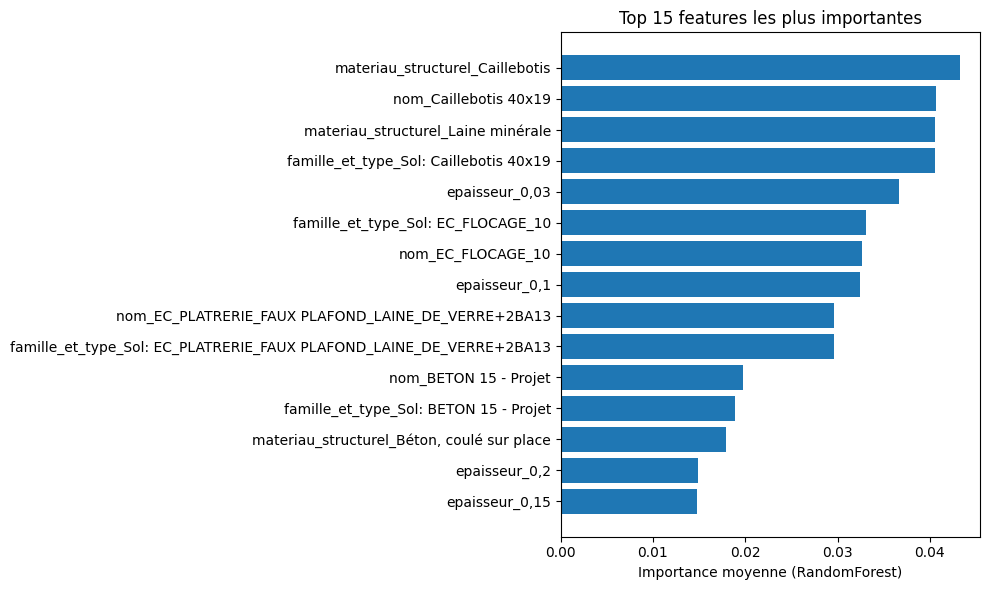

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Récupérer le modèle entraîné
rf_multi = pipeline.named_steps['model']

# Récupérer les noms des features après preprocessing
feature_names = []
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    num_features_out = num_features
    # Pour les features catégorielles, récupérer les noms encodés
    cat_features_out = []
    if cat_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_features_out = encoder.get_feature_names_out(cat_features)
    feature_names = list(num_features_out) + list(cat_features_out)
else:
    feature_names = list(X.columns)

# Calculer l'importance moyenne des features sur toutes les cibles
importances = np.mean([est.feature_importances_ for est in rf_multi.estimators_], axis=0)

# DataFrame pour affichage
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Afficher les 15 features les plus importantes
print(feat_imp.head(15))

# Visualisation
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])
plt.xlabel("Importance moyenne (RandomForest)")
plt.title("Top 15 features les plus importantes")
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import classification_report

# Classification report pour chaque cible séparément
for i, col in enumerate(y_test.columns):
	print(f"=== Classification Report for {col} ===")
	print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

=== Classification Report for 011ec_lot ===
              precision    recall  f1-score   support

  ETANCHEITE       1.00      1.00      1.00        25
    EXISTANT       0.00      0.00      0.00         0
          GO       1.00      1.00      1.00      1099
  METALLIQUE       1.00      0.94      0.97        31
   PLATRERIE       1.00      1.00      1.00        18

    accuracy                           1.00      1173
   macro avg       0.80      0.79      0.79      1173
weighted avg       1.00      1.00      1.00      1173

=== Classification Report for 012ec_ouvrage ===
              precision    recall  f1-score   support

         CES       1.00      0.97      0.99        74
     CORBEAU       1.00      1.00      1.00         1
     DALLAGE       0.91      0.96      0.94        53
DALLE PORTEE       0.53      0.45      0.49        20
    LONGRINE       1.00      1.00      1.00         3
    PLANCHER       0.97      0.99      0.98       980
      RADIER       1.00      0.52      0

/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 